# Nearly Constant Acceleration Model
# 3 dimensional CWPA model
# Radar measurement vectors consisting of (range,elevation,azimuth)
# Created: 17 June 2016

In [1]:
# Import the required libraries
import numpy as np
import math
from numpy import linalg
import scipy.linalg
from numpy.random import randn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define variables for the simulation
dt = 0.1 ; #[s]
t = np.arange(0,20,dt,dtype=float) # [s]

In [3]:
dimensionality = 3; # 3 dimensional problem
nStates = 3; # 3 states per dimension. position,velocity and acceleration
nVars = nStates*dimensionality; 
x_state = np.zeros([nVars,len(t)],dtype=float);

def fn_Generate_STM_polynom(zeta,nStates):
    # fn_Generate_STM_polynom creates the state transition matrix for polynomial models 
    # of degree (nStates-1) over a span of transition of zeta [s].
    # Polynomial models are a subset of the class of constant-coefficient linear DEs.
    # Refer to: Tracking Filter Engineering, Norman Morrison.
    stm = np.eye(nStates,dtype=float);
    for yindex in range (0,nStates):
        for xindex in range (yindex,nStates): # STM is upper triangular
            stm[yindex,xindex] = np.power(zeta,xindex-yindex)/float(math.factorial(xindex-yindex));
    return stm;     

def fn_Generate_STM_polynom_3D(zeta,nStates,dimensionality):
    # fn_Generate_STM_polynom_3D generates the full state transition matrix for 
    # the required dimensionality.
    stm = fn_Generate_STM_polynom(dt,nStates);
    stm3 = fn_Create_Concatenated_Block_Diag_Matrix(stm,dimensionality-1);
    return stm3;

def fn_Create_Concatenated_Block_Diag_Matrix(R,stacklen):
    # fn_Create_Concatenated_Block_Diag_Matrix creates a block diagonal matrix of size (stacklen) x (stacklen)
    # whose diagonal blocks are copies of the matrix R.
    L = [R]; 
    for index in range (0,stacklen):
        L.append(R);
        ryn = scipy.linalg.block_diag(*L);
    return ryn;

In [4]:
# The following 3 functions implement coordinate transformations according to pg 122 in 
#Tracking Filter Engineering, Norman Morrison.
def fnH(Xinput):
    # Nonlinear measurement function.
    # Sensor measures range and look angles.
    Xinput_polar = np.zeros([3],dtype=float);
    # Calculate range
    Xinput_polar[0] = np.linalg.norm(Xinput);
    # Calculate elevation
    Xinput_polar[1] = np.arctan(Xinput[2]/np.linalg.norm(Xinput[0:2]));
    # Calculate azimuth
    Xinput_polar[2] = np.arctan2(Xinput[0],Xinput[1]);
    return Xinput_polar

def fnHinv(Xinput):
    # Xinput[0] = range
    # Xinput[1] = elevation
    # Xinput[2] = azimuth
    Xout = np.zeros([3],dtype=float);
    Xout[0] = Xinput[0]*np.cos(Xinput[1])*np.sin(Xinput[2]); # x
    Xout[1] = Xinput[0]*np.cos(Xinput[1])*np.cos(Xinput[2]); # y
    Xout[2] = Xinput[0]*np.sin(Xinput[1]); # z
    return Xout

In [5]:
# Initialize  state vector
x_state[:,0] = np.array([1000,180,8,
                         900,190,8,
                         1300,170,8],dtype=float);

# Measurement noise covariance matrix
R = np.diag([np.square(1),np.square(0.01),np.square(0.01)]); 
y_meas = np.zeros([3,len(t)],dtype=float); # measurement vector.

# Find continuous-time process covariance matrix, then discretize it.
qtilde = 0.0001*x_state[8,0]/np.sqrt(dt); # Choice of process noise intensity.
# The theory behind Discretized Continuous-time kinematic models is discussed thoroughly
# in Bar-Shalom, Rong Li, Kirubarajan: Estimation with applications to tracking and navigation.
Qc00 = np.power(dt,5)/20; # See discussion in section 6.2.3
Qc01 = np.power(dt,4)/8;
Qc02 = np.power(dt,3)/6;
Qc21 = np.square(dt)/2
Qc = np.array([[Qc00,Qc01,Qc02],[Qc01,Qc02*2,Qc21],[Qc02,Qc21,dt]],dtype=float);
Qd = Qc*qtilde; # process noise covariance matrix for the 1D case
Qd3 = fn_Create_Concatenated_Block_Diag_Matrix(Qd,dimensionality-1); # Generate the corresponding matrix for the 3D case

# Initial estimate of state vector
m0 = x_state[:,0] + np.random.multivariate_normal([0,0,0,0,0,0,0,0,0],Qd3);
P0 = np.diag([100.0,10.0,1.0,
              100.0,10.0,1.0,
              100.0,10.0,1.0]);  # Initial covariance matrix estimate, indicating high uncertainty. 

In [6]:
pos = np.array([m0[0],m0[3],m0[6]],dtype=float);
y_meas[:,0] = fnH(pos); # initialize measurement vector.
stm3 = fn_Generate_STM_polynom_3D(dt,nStates,dimensionality);

for index in range (1,len(t)):
    wn = np.random.multivariate_normal([0,0,0,0,0,0,0,0,0],Qd3);
    x_state[:,index] = np.dot( stm3,x_state[:,index-1] ) + wn;
    # sensor measurements are contaminated with awgn of covariane R.
    vn = np.random.multivariate_normal([0,0,0],R);
    pos = np.array([x_state[0,index],x_state[3,index],x_state[6,index]],dtype=float);
    y_meas[:,index] = fnH(pos)+ vn;

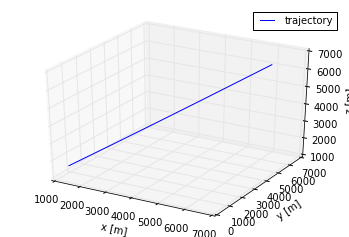

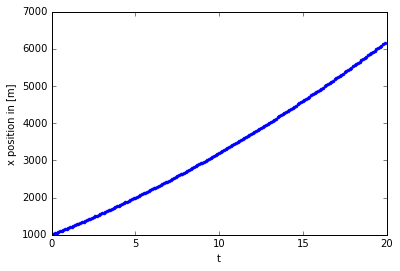

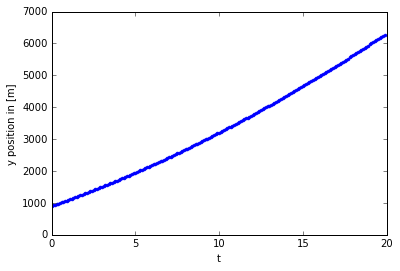

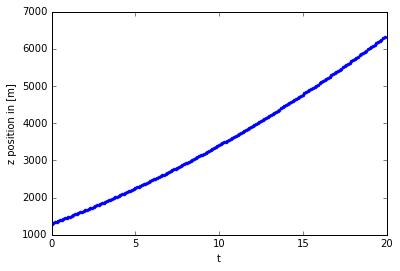

In [7]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mpl.rcParams['legend.fontsize'] = 10

ax = fig.gca(projection='3d')
ax.plot(x_state[0,:], x_state[3,:], x_state[6,:], label='trajectory')
ax.legend()

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

plt.show()

fig = plt.figure()
plt.plot(t,x_state[0,:],'b.')
plt.ylabel('x position in [m]')
plt.xlabel('t')
plt.show()

fig = plt.figure()
plt.plot(t,x_state[3,:],'b.')
plt.ylabel('y position in [m]')
plt.xlabel('t')
plt.show()

fig = plt.figure()
plt.plot(t,x_state[6,:],'b.')
plt.ylabel('z position in [m]')
plt.xlabel('t')
plt.show()

In [8]:
def fnUT_sigmas(X,P,params_vec):
    # Implementation of ut_sigmas.m of the ekfukf toolbox
    A = np.linalg.cholesky(P);
    n = params_vec[3]; kappa = params_vec[2];
    sigmas = np.vstack((np.zeros_like(X),A ,-A) );
    c  = n + kappa;
    sigmas = np.sqrt(c)*sigmas;
    sigmas  = np.add(sigmas,np.tile(X,(2*n+1,1)));
    return sigmas

def fnUT_weights(params):
    # X - state vector
    # P - covariance matrix
    # params_vec = [alpha,beta,kappa,n]
    # emulates ut_weights.m of the ekfukftoolbox
    alpha = float(params[0]); 
    beta = float(params[1]);
    kappa = float(params[2]); 
    n = params[3];
    lambd = np.square(alpha) * (float(n) + kappa) - float(n);
    Weights_Mean = np.zeros((2*n+1),dtype=float);
    Weights_Cov = np.zeros((2*n+1),dtype=float);
    Weights_Mean[0] = lambd/(float(n)+lambd);
    Weights_Cov[0] = lambd/(float(n)+lambd) + (1-np.square(alpha) + beta);
    for index in range(1,2*n+1):
        Weights_Mean[index] = 1 / (2 * (float(n) + lambd));
        Weights_Cov[index] = Weights_Mean[index];
    return Weights_Mean,Weights_Cov

In [9]:
alpha = 1;
beta = 2;
n = 9;
kappa = 0;
params =np.array([alpha,beta,kappa,n],dtype=int);

In [10]:
## unscented Kalman filter functions ####
# Note that these functions are tailored for Kinematic models.
def fnUKF_predict( stm, m, P, Q,params_vec):
    # Form the sigma points of x
    sigmas = fnUT_sigmas(m,P,params_vec);
    # Compute weights
    Wm,Wc = fnUT_weights(params_vec);  
    n = params_vec[3];
    # Propagate sigma points through the (non)linear model.
    yo = np.dot(stm,sigmas[0,:]);
    Y = np.zeros([n,2*n+1],dtype=float); # sigma points of y
    Y[:,0] = yo;
    
    mu = Wm[0]*Y[:,0];
    for index in range(1,2*n+1):
        Y[:,index] = np.dot(stm,sigmas[index,:]);
        mu +=  Wm[index]*Y[:,index];

    Sk  = np.zeros([n,n],dtype=float);
    
    for index in range (0,2*n+1):
        diff = np.subtract(Y[:,index],mu);
        produ = np.multiply.outer(diff,diff); 
        Sk = np.add(Sk,Wc[index]*produ);
        
    m_pred = mu;
    P_pred = np.add(Sk,Q);
    # m_pred and P_pred are the predicted mean state vector and covariance
    # matrix at the current time step before seeing the measurement.
    return m_pred,P_pred

def fnUKF_update(m_minus, P_minus, y,fnH,R,params_vec):
    # Form the sigma points of x
    sigmas = fnUT_sigmas(m_minus,P_minus,params_vec);
    # Compute weights
    Wm,Wc = fnUT_weights(params_vec);  
    
    n = params_vec[3];
    # Propagate sigma points through the (non)linear model.    
    pos = np.array([sigmas[0,0],sigmas[0,3],sigmas[0,6]],dtype=float);
    yo = fnH(pos);
    Y = np.zeros([np.shape(yo)[0],2*n+1],dtype=float); # sigma points of y
    Y[:,0] = yo;
    
    mu = Wm[0]*Y[:,0];
    for index in range(1,2*n+1):
        pos = np.array([sigmas[index,0],sigmas[index,3],sigmas[index,6]],dtype=float);
        Y[:,index] = fnH(pos);
        mu = Wm[index]*Y[:,index];

    Sk  = np.zeros([np.shape(yo)[0],np.shape(yo)[0]],dtype=float);
    Ck  = np.zeros([n,np.shape(yo)[0]],dtype=float);
    
    for index in range (0,2*n+1):
        diff = np.subtract(Y[:,index],mu);
        produ = np.multiply.outer(diff,diff); 
        Sk = np.add(Sk,Wc[index]*produ); 
        diff1 = np.subtract(sigmas[index,:],m_minus);
        produ1 = np.multiply.outer(diff1,diff);    
        Ck = np.add(Ck,Wc[index]*produ1); 
                
    Sk = np.add(Sk,R);     
    KalmanGain = np.dot(Ck,np.linalg.inv(Sk));

    # Calculate estimated mean state vector and its covariance matrix.
    m = m_minus + np.dot(KalmanGain ,np.subtract(y,mu));
    P = np.subtract(P_minus,np.dot(np.dot(KalmanGain,Sk),np.transpose(KalmanGain)));
    return m,P

In [11]:
## Filter the sensor data  ###################################################
x_state_hat = np.zeros([n,len(t)],dtype=float)
x_state_hat[:,0] = m0;
P_hat = np.zeros([n,n,len(t)],dtype=float);
P_hat[:,:,0] = P0;

for index in range (1,x_state_hat.shape[1]):
    m_pred,P_pred = fnUKF_predict( stm3,x_state_hat[:,index-1], P_hat[:,:,index-1],Qd3,params);
    x_state_hat[:,index],P_hat[:,:,index] = fnUKF_update(m_pred, P_pred, y_meas[:,index],fnH,R,params);

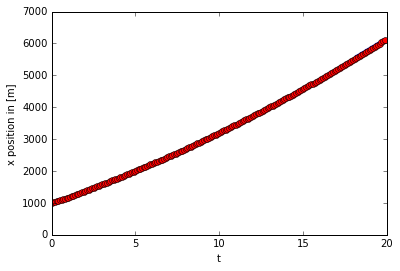

In [12]:
fig = plt.figure()
plt.plot(t,x_state[0,:],'b.')
plt.plot(t,x_state_hat[0,:],'ro')
plt.ylabel('x position in [m]')
plt.xlabel('t')
plt.show()

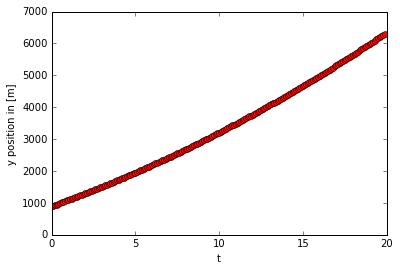

In [13]:
fig = plt.figure()
plt.plot(t,x_state[3,:],'b.')
plt.plot(t,x_state_hat[3,:],'ro')
plt.ylabel('y position in [m]')
plt.xlabel('t')
plt.show()

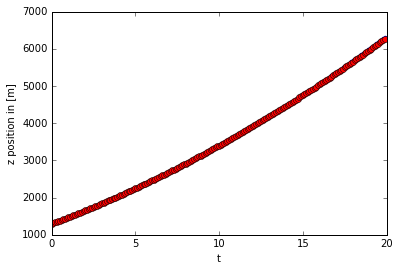

In [14]:
fig = plt.figure()
plt.plot(t,x_state[6,:],'b.')
plt.plot(t,x_state_hat[6,:],'ro')
plt.ylabel('z position in [m]')
plt.xlabel('t')
plt.show()

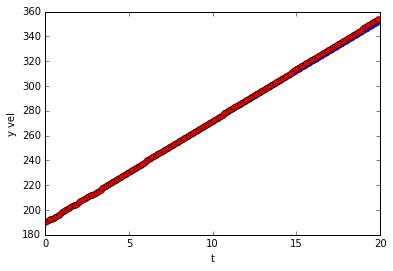

In [15]:
fig = plt.figure()
plt.plot(t,x_state[4,:],'b.')
plt.plot(t,x_state_hat[4,:],'ro')
plt.ylabel('y vel')
plt.xlabel('t')
plt.show()

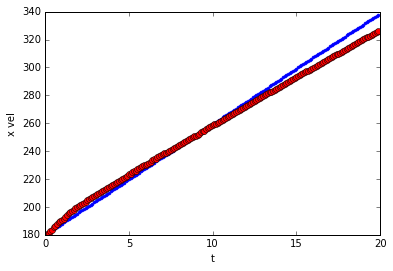

In [16]:
fig = plt.figure()
plt.plot(t,x_state[1,:],'b.')
plt.plot(t,x_state_hat[1,:],'ro')
plt.ylabel('x vel')
plt.xlabel('t')
plt.show()

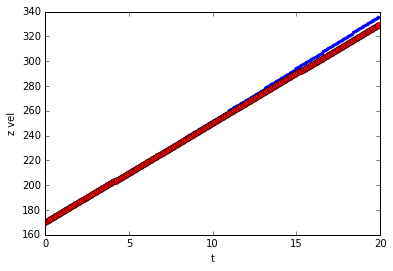

In [17]:
fig = plt.figure()
plt.plot(t,x_state[7,:],'b.')
plt.plot(t,x_state_hat[7,:],'ro')
plt.ylabel('z vel')
plt.xlabel('t')
plt.show()

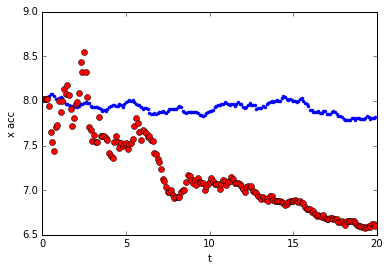

In [18]:
fig = plt.figure()
plt.plot(t,x_state[2,:],'b.')
plt.plot(t,x_state_hat[2,:],'ro')
plt.ylabel('x acc')
plt.xlabel('t')
plt.show()

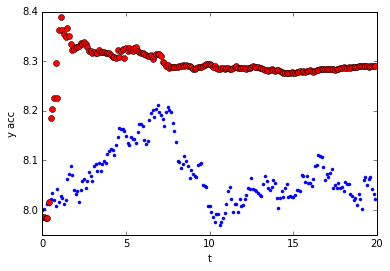

In [19]:
fig = plt.figure()
plt.plot(t,x_state[5,:],'b.')
plt.plot(t,x_state_hat[5,:],'ro')
plt.ylabel('y acc')
plt.xlabel('t')
plt.show()

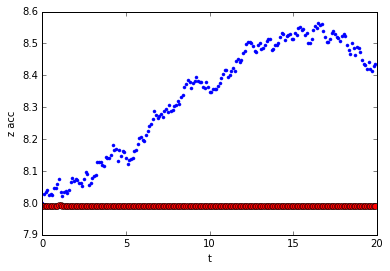

In [20]:
fig = plt.figure()
plt.plot(t,x_state[8,:],'b.')
plt.plot(t,x_state_hat[8,:],'ro')
plt.ylabel('z acc')
plt.xlabel('t')
plt.show()

In [21]:
## Compute the RMS Error ######################################################
epsilon = np.zeros_like(y_meas,dtype=float);
squared_error = np.zeros_like(t,dtype=float);
Rinv = np.linalg.inv(R);
for index in range (0,x_state_hat.shape[1]-1):
    pos = np.array([x_state_hat[0,index],x_state_hat[3,index],x_state_hat[6,index]],dtype=float);
    epsilon[:,index] = np.subtract(y_meas[:,index],fnH(pos));
    squared_error[index] = np.dot(np.dot(np.transpose(epsilon[:,index]),Rinv),epsilon[:,index]);
mse = np.sum(squared_error)/float(np.shape(epsilon)[0]*np.shape(squared_error)[0]);
rmse = math.sqrt(mse);
print rmse

10.5649851221


In [23]:
deg = 0.03
rad = np.pi*deg/180.0
print rad

0.000523598775598
